In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import roc_curve, roc_auc_score,classification_report,precision_recall_fscore_support, accuracy_score, confusion_matrix, precision_score

In [2]:
gnb=GaussianNB()
mnb=MultinomialNB()
bnb=BernoulliNB()

In [3]:
cv=CountVectorizer()
tfidf=TfidfVectorizer(max_features=3000)

In [4]:
wc=WordCloud(background_color="black", width=500, height=400)

In [5]:
ps=PorterStemmer()

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
url="/content/drive/MyDrive/SpamDetectionData/spam.csv"

In [8]:
df=pd.read_csv(url,encoding='ISO-8859-1')

In [9]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
424,ham,Send this to ur friends and receive something ...,NaN,NaN,NaN
2882,ham,Anything lor is she coming?,NaN,NaN,NaN
2003,ham,S....s...india going to draw the series after ...,NaN,NaN,NaN
887,ham,Y dun cut too short leh. U dun like ah? She fa...,NaN,NaN,NaN
2077,ham,Hey hun-onbus goin 2 meet him. He wants 2go ou...,NaN,NaN,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


# **1. Data Cleaning**

#### **Note**: *Drop last 3 columns as they have mostly null values*




In [11]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)
df.sample(2)

,v1,v2
5335,ham,No. It's not pride. I'm almost &lt;#&gt; yea...
2956,ham,I would but I'm still cozy. And exhausted from...


#### **Note:** *Renaming the columns*

In [12]:
df.rename(columns={"v1":"Target","v2":"Text"},inplace=True)
df.sample(2)

,Target,Text
4384,spam,Do you want a New Nokia 3510i Colour Phone Del...
3747,ham,"A bit of Ur smile is my hppnss, a drop of Ur t..."


import numpy as np
from google.colab import autoviz
df_6334843228859889402 = autoviz.get_registered_df('df_6334843228859889402')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_6334843228859889402, *['Target'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6334843228859889402 = autoviz.get_registered_df('df_6334843228859889402')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_6334843228859889402, *['Text'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6334843228859889402 = autoviz.get_registered_df('df_6334843228859889402')

def heatmap(df, x_colname, y_colname, figsize=(2, 2)):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=figsize)
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=sns.cubehelix_palette(start=.5, rot=-.8))
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df_6334843228859889402, *['Target', 'Text'], **{})
chart

#### **Note:** *Encoding the target values from spam and ham*

In [13]:
encoder=LabelEncoder()
df['Target']=encoder.fit_transform(df['Target'])

In [14]:
df.sample(5)

,Target,Text
5461,0,Ok i thk i got it. Then u wan me 2 come now or...
5305,0,\Hi missed your Call and my mumHas beendroppin...
3054,1,EASTENDERS TV Quiz. What FLOWER does DOT compa...
4019,0,University of southern california.
3674,0,Whos this am in class:-)


#### **Note:** *Checking any missing values*

In [15]:
df.isnull().sum()

Target    0
Text      0
dtype: int64

#### **Note:** *Check and Remove Duplicate values*

In [16]:
df.duplicated().sum()

403

In [17]:
df=df.drop_duplicates(keep='first')
df.duplicated().sum()

0

# **2. Exploratory Data Analysis**

#### **Note:** *We will check how many Hams and Spams are there*

In [18]:
counts=df['Target'].value_counts()
values=counts.values
index=counts.index

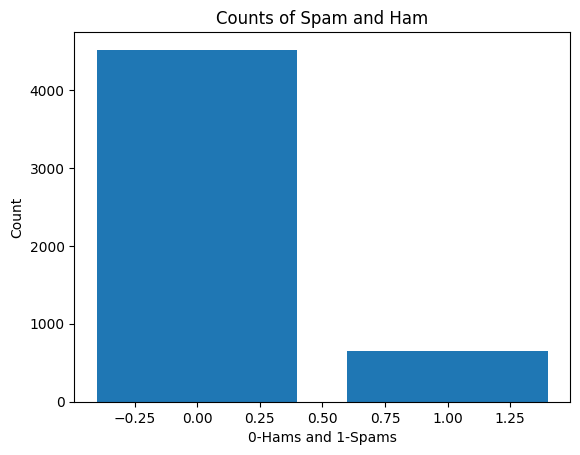

In [19]:
plt.bar(index, values)
plt.title("Counts of Spam and Ham")
plt.xlabel("0-Hams and 1-Spams")
plt.ylabel("Count")
plt.show()

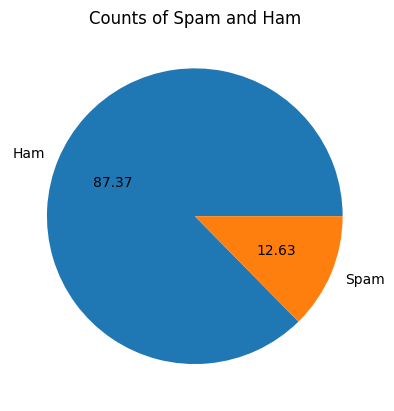

In [20]:
plt.pie(values, labels=['Ham',"Spam"], autopct="%0.2f")
plt.title("Counts of Spam and Ham")
plt.show()

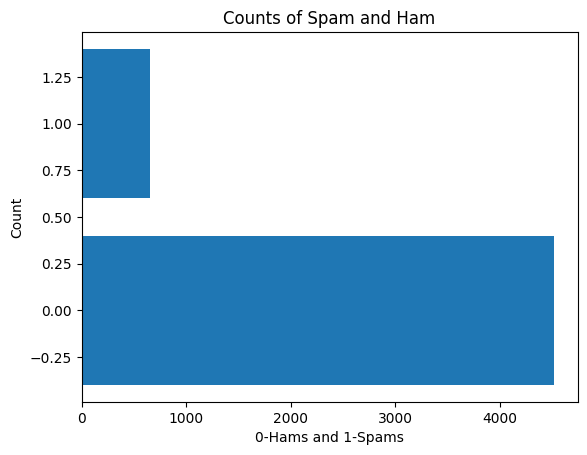

In [21]:
plt.barh(index, values)
plt.title("Counts of Spam and Ham")
plt.xlabel("0-Hams and 1-Spams")
plt.ylabel("Count")
plt.show()

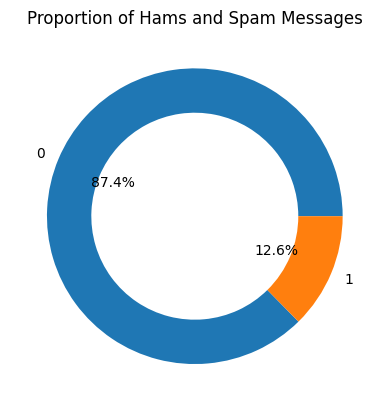

In [22]:
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', wedgeprops=dict(width=0.3))
plt.title('Proportion of Hams and Spam Messages')
plt.show()

#### **Note:** **punkt** provides a pre-trained tokenizers for various languages. the tokenizers breaks down text into individual words or sentences.

> to use punkt we need to first download it using

```
import nltk
nltk.download('punkt')

```





In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### Note: *We will create two more columns in the data*
1. first will be number of characaters in the SMS
2. Second will be number of words in SMS
3. Third will be number if sentences in SMS



In [24]:
# Creating column with number of words in a SMS
df['Num_Characters']=df['Text'].apply(len)

In [25]:
# Creating a column with number of words in a SMS
df['Num_Words']=df.Text.apply(lambda x: len(nltk.word_tokenize(x)))

In [26]:
# Creating a column with number of sentences in a SMS
df['Num_Sentences']=df.Text.apply(lambda x: len(nltk.sent_tokenize(x)))

In [27]:
df

,Target,Text,Num_Characters,Num_Words,Num_Sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2
5570,0,The guy did some bitching but I acted like i'd...,125,27,1


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5169 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Target          5169 non-null   int64 
 1   Text            5169 non-null   object
 2   Num_Characters  5169 non-null   int64 
 3   Num_Words       5169 non-null   int64 
 4   Num_Sentences   5169 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 242.3+ KB


In [29]:
df.describe()

,Target,Num_Characters,Num_Words,Num_Sentences
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.455794,1.965564
std,0.332253,58.236293,13.324758,1.448541
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,38.000000


In [30]:
df[df.Target==0].describe()

,Target,Num_Characters,Num_Words,Num_Sentences
count,4516.0,4516.000000,4516.000000,4516.000000
mean,0.0,70.459256,17.123782,1.820195
std,0.0,56.358207,13.493970,1.383657
min,0.0,2.000000,1.000000,1.000000
25%,0.0,34.000000,8.000000,1.000000
50%,0.0,52.000000,13.000000,1.000000
75%,0.0,90.000000,22.000000,2.000000
max,0.0,910.000000,220.000000,38.000000


In [31]:
df[df.Target==1].describe()

,Target,Num_Characters,Num_Words,Num_Sentences
count,653.0,653.000000,653.000000,653.000000
mean,1.0,137.891271,27.667688,2.970904
std,0.0,30.137753,7.008418,1.488425
min,1.0,13.000000,2.000000,1.000000
25%,1.0,132.000000,25.000000,2.000000
50%,1.0,149.000000,29.000000,3.000000
75%,1.0,157.000000,32.000000,4.000000
max,1.0,224.000000,46.000000,9.000000


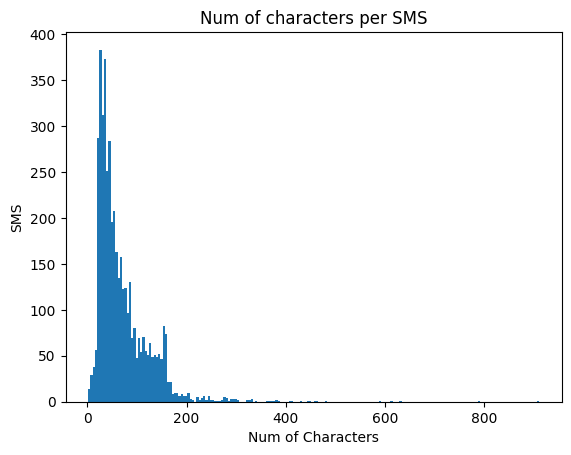

In [32]:
plt.hist(df[df.Target==0].Num_Characters,bins=200)
plt.ylabel("SMS")
plt.xlabel("Num of Characters")
plt.title("Num of characters per SMS")
plt.show()

<Axes: xlabel='Num_Characters', ylabel='Count'>

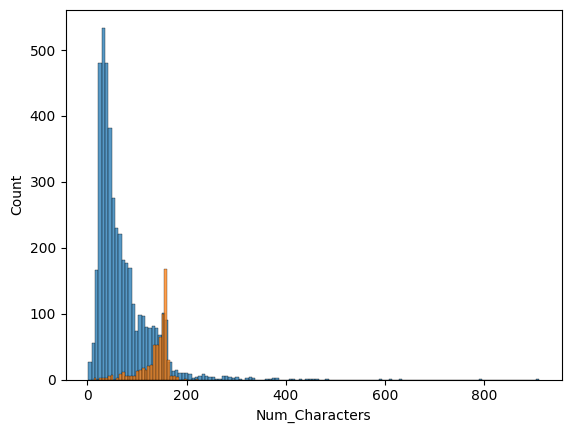

In [33]:
sns.histplot(df[df.Target==0].Num_Characters)
sns.histplot(df[df.Target==1].Num_Characters)

<Axes: xlabel='Num_Words', ylabel='Count'>

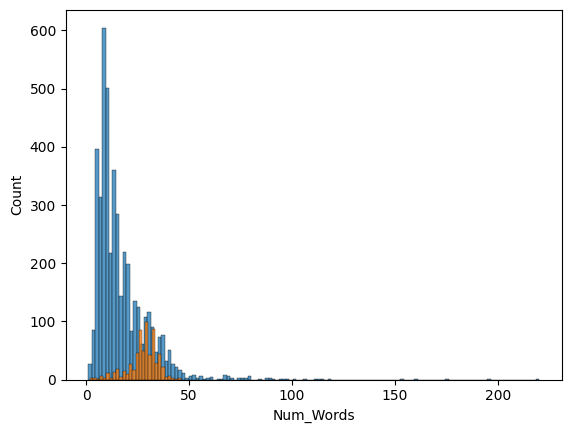

In [34]:
sns.histplot(df[df.Target==0].Num_Words)
sns.histplot(df[df.Target==1].Num_Words)

<Axes: xlabel='Num_Sentences', ylabel='Count'>

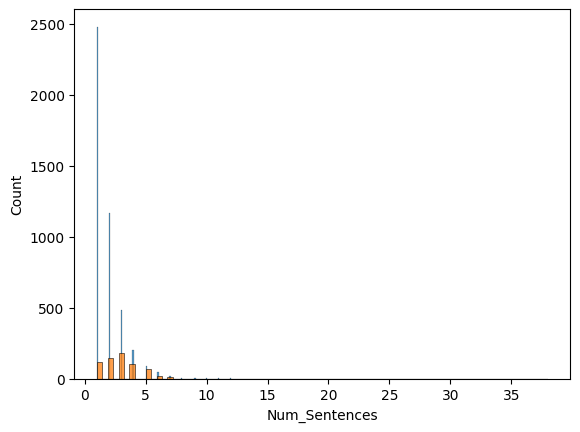

In [35]:
sns.histplot(df[df.Target==0].Num_Sentences)
sns.histplot(df[df.Target==1].Num_Sentences)

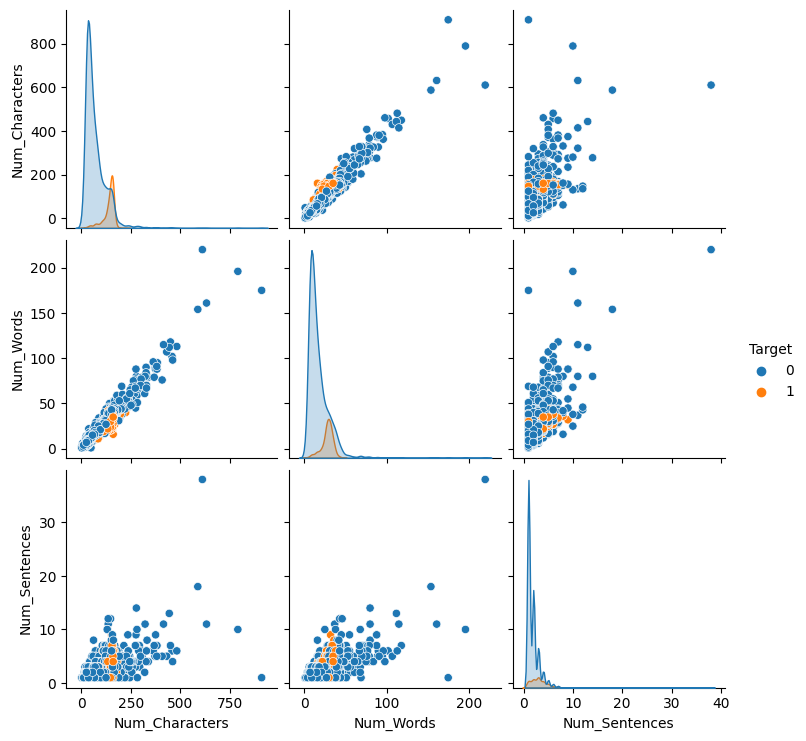

In [36]:
sns.pairplot(df, hue="Target")

In [37]:
df.corr()

<ipython-input-37-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Target,Num_Characters,Num_Words,Num_Sentences
Target,1.000000,0.384717,0.262912,0.263939
Num_Characters,0.384717,1.000000,0.965760,0.624139
Num_Words,0.262912,0.965760,1.000000,0.679971
Num_Sentences,0.263939,0.624139,0.679971,1.000000


<ipython-input-38-8df7bcac526d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<Axes: >

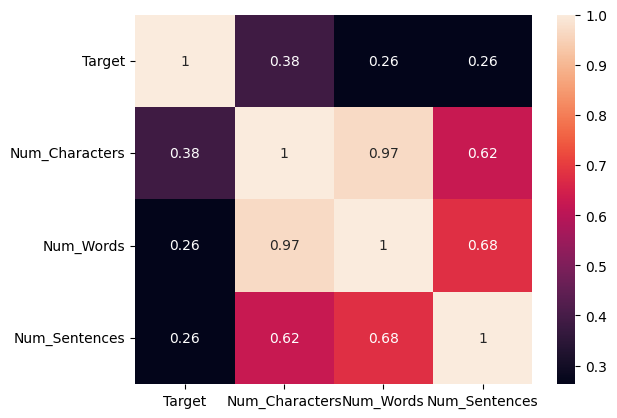

In [38]:
sns.heatmap(df.corr(),annot=True)

# 3. Text Preprocessing

In [39]:
def transform_text(text):
  # change text into lower case
  text=text.lower()

  # tokenize words
  text=nltk.word_tokenize(text)

  # Removing special characters
  y=[]
  for word in text:
    if word.isalnum():
      y.append(word)

  # Remove panctuations and stopwords
  text=y[:]
  y.clear()

  for word in text:
    if word not in stopwords.words("english") and word not in string.punctuation:
      y.append(word)

  #Stemming

  text=y[:]
  y.clear()

  for i in text:
    y.append(ps.stem(i))

  return " ".join(y)

In [40]:
transform_text("ABC Def % 12& !! _ dancing danced ran running run")

'abc def 12 danc danc ran run run'

In [41]:
df['transform_text']=df.Text.apply(transform_text)

In [42]:
df

,Target,Text,Num_Characters,Num_Words,Num_Sentences,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4,2nd time tri 2 contact u pound prize 2 claim e...
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2,piti mood suggest
5570,0,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like interest buy someth els nex...


In [43]:
spam_word_cloud=wc.generate(df[df['Target']==1].transform_text.str.cat(sep=" "))

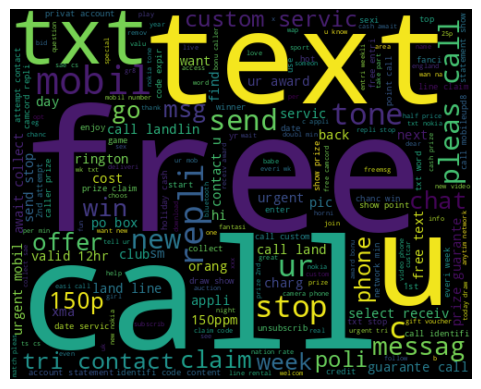

In [44]:
plt.imshow(spam_word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [45]:
ham_word_cloud=wc.generate(df[df.Target==0].transform_text.str.cat(sep=" "))

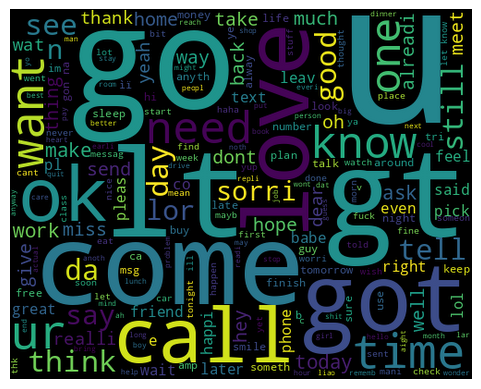

In [46]:
plt.imshow(ham_word_cloud,interpolation="lanczos")
plt.axis("off")
plt.show()

In [47]:
spam_corpus=[]
for msg in df[df.Target==1].transform_text.tolist():
  for word in msg.split():
    spam_corpus.append(word)
print(len(spam_corpus))

9939


In [48]:
ham_corpus=[]
for msg in df[df.Target==0].transform_text.tolist():
  for word in msg.split():
    ham_corpus.append(word)
print(len(ham_corpus))

35404


#### Note: find top most used words in spam text

In [49]:
most_common_words_spam=pd.DataFrame(Counter(spam_corpus).most_common(30))
most_common_words_ham=pd.DataFrame(Counter(ham_corpus).most_common(30))

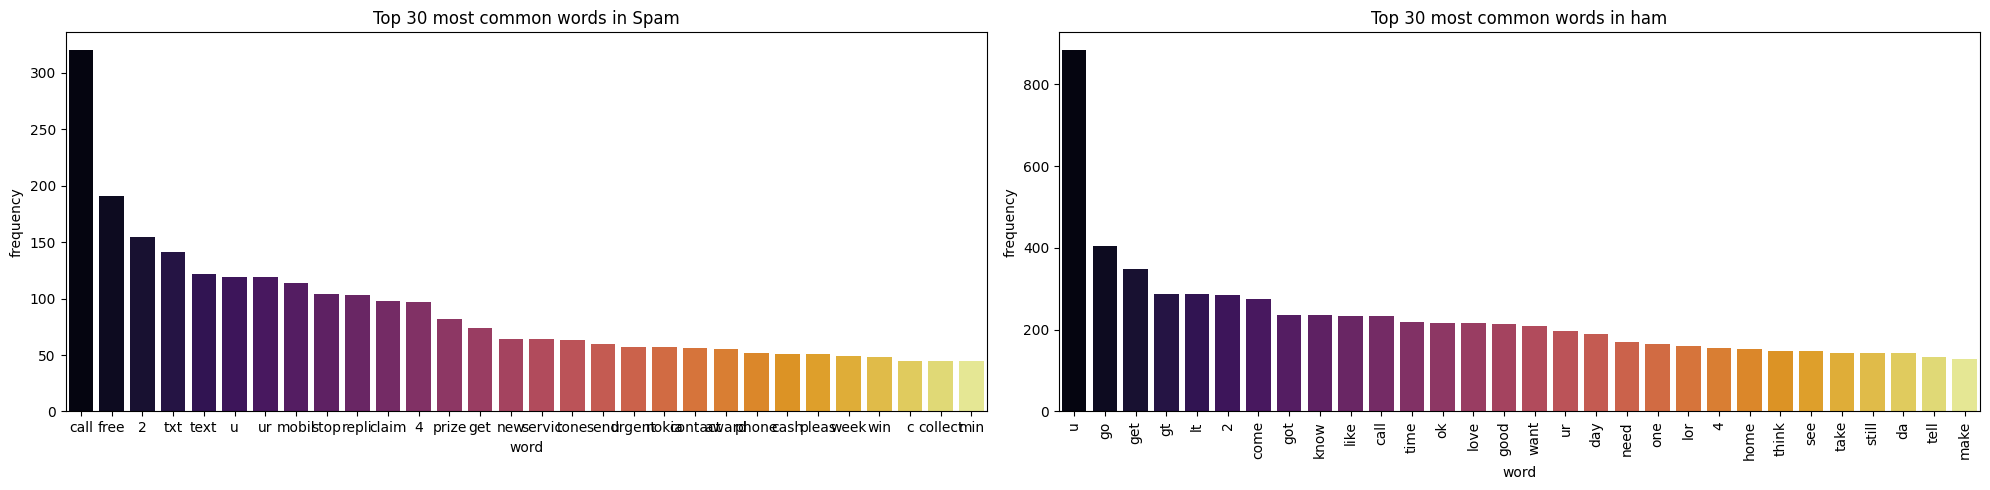

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(x=0,y=1,data=most_common_words_spam, palette='inferno',ax=ax[0])
ax[0].set(xlabel="word", ylabel="frequency", title="Top 30 most common words in Spam")
plt.xticks(rotation=90)

sns.barplot(x=0,y=1,data=most_common_words_ham, palette='inferno',ax=ax[1])
ax[1].set(xlabel="word", ylabel="frequency", title="Top 30 most common words in ham")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 4. Model Building

#### **Note:** *Since we have input x that is tranform_text fild as text, so we need to convert it into numericals. For this we have various algorithm availble in sklearn like CountVectorizer, TfidfVectorizer, HashingVectorizer, BinaryVectorizer, FeatureHasher, DictVectorizer.*

In [51]:
# since cv.fit_transform(df['transform_text']) returns a sparse array so we need to convert it into array
x_cv=cv.fit_transform(df['transform_text']).toarray() #CountVectorizer
x_tfidf=tfidf.fit_transform(df['transform_text']).toarray() #tfidfVectorizer
print("CountVectorizer",x_cv.shape)
print("tfidfVectorizer",x_cv.shape)

CountVectorizer (5169, 6708)
tfidfVectorizer (5169, 6708)


In [52]:
y=df.Target.values
print(y.shape)

(5169,)


#### Note:- *split the data into training data and test data using sklearn's library*

In [53]:
xTrain_cv, xTest_cv, yTrain_cv, yTest_cv= train_test_split(x_cv,y,test_size=0.2, random_state=42)  #CountVectorizer
xTrain_tfidf, xTest_tfidf, yTrain_tfidf, yTest_tfidf= train_test_split(x_tfidf,y,test_size=0.2, random_state=42)  #tfidfVectorizer

In [54]:
print("CountVectorizer",xTrain_cv.shape)
print("tfidfVectorizer",xTrain_tfidf.shape)

CountVectorizer (4135, 6708)
tfidfVectorizer (4135, 3000)


In [55]:
print("CountVectorizer",xTest_cv.shape)
print("tfidfVectorizer",xTest_tfidf.shape)

CountVectorizer (1034, 6708)
tfidfVectorizer (1034, 3000)


#### **Note:** *There are various algorithms to predict spam text some of them are Naive Bayes, Support Vector Machines (SVM), Random Forest, Gradient Boosting, Deep Learning, Logistic Regression*

- In Naive bayes there are three algorithms
  1. Gaussian Naive Bayes
  2. Bernoulli Naive Bayes
  3. Multinomial Naive Bayes  

#### **1. Using Gaussian Naive Bayes**

In [56]:
###########Convectorizer#########
gnb.fit(xTrain_cv,yTrain_cv)
y_predict_gnb_cv=gnb.predict(xTest_cv)
###########tfidfVectorizer#########
gnb.fit(xTrain_tfidf,yTrain_tfidf)
y_predict_gnb_tfidf=gnb.predict(xTest_tfidf)

#### **2. Multinomial Naive Bayes**

In [57]:
###########Convectorizer#########
mnb.fit(xTrain_cv,yTrain_cv)
y_predict_mnb_cv=mnb.predict(xTest_cv)
###########tfidfVectorizer#########
mnb.fit(xTrain_tfidf,yTrain_tfidf)
y_predict_mnb_tfidf=mnb.predict(xTest_tfidf)

#### **3. Bernoulli Naive Bayes**

In [58]:
###########Convectorizer#########
bnb.fit(xTrain_cv,yTrain_cv)
y_predict_bnb_cv=bnb.predict(xTest_cv)
###########tfidfVectorizer#########
bnb.fit(xTrain_tfidf,yTrain_tfidf)
y_predict_bnb_tfidf=bnb.predict(xTest_tfidf)

#### Evaluation Methods

- **Accuracy:** It is the ratio of correct predictions to the total number of predictions.

    - *Note: It is a common evaluation metric for balanced datasets but may not be suitable for imbalanced datasets.*

- **Precision:** It represents the proportion of correctly predicted positive instances out of all instances predicted as positive.

- **Recall/sensitivity:** It measures the proportion of correctly predicted positive instances out of all actual positive instances.

- **F1-score:** It is the harmonic mean of precision and recall, providing a balanced measure of both metrics.

    - *Note: Precision, recall, and F1-score are commonly used for binary classification tasks.*

- **Confusion Matrix:** It shows the counts of true positives, true negatives, false positives, and false negatives. It helps in analyzing the type and frequency of prediction errors made by the model.

- **Receiver Operating Characteristic (ROC) Curve:**: ROC curve is a graphical representation that illustrates the trade-off between the true positive rate (TPR) and the false positive rate (FPR) at various classification thresholds. The area under the ROC curve (AUC-ROC) is often used as a summary measure of the model's classification performance.

- **Cross-Validation:** Cross-validation is a technique used to estimate the performance of a model on unseen data. It involves splitting the dataset into multiple subsets (folds), training the model on a subset of folds, and evaluating it on the remaining fold. This helps in obtaining a more robust estimate of the model's performance.

----------------------------------------------------------------------------
<center>

### Confusion matrix

```
                                          
                 |    Predicted Positive  |   Predicted Negative   |
                 ------------------------------------------------------------
Actual Positive  |   TP (True Positive)   |   FN (False Negative)  |
-----------------------------------------------------------------------------
Actual Negative  |   FP (False Positive)  |   TN (True Negative)   |
-----------------------------------------------------------------------------
```
    1. True Positive (TP): The model correctly predicted the positive class (e.g., spam) when it was actually positive.

    2. False Negative (FN): The model incorrectly predicted the negative class (e.g., not spam) when it was actually positive.
    
    3. False Positive (FP): The model incorrectly predicted the positive class when it was actually negative.
    
    4. True Negative (TN): The model correctly predicted the negative class when it was actually negative.


  **Accuracy:** `(TP + TN) / (TP + TN + FP + FN).`

  **Precision:** `TP / (TP + FP).`

  **Recall:** `TP / (TP + FN).`

  **Specificity:** `TN / (TN + FP)`

  **F1-score:** `The harmonic mean of precision and recall, providing a balanced measure of both metrics.`
</center>




#### 1. Accuracy Score

- Countvectorizer

In [59]:
print("Gaussian Naive Bayes", accuracy_score(yTest_cv,y_predict_gnb_cv ))
print("-----------------------------------------------")
print("Multinomial Naive Bayes", accuracy_score(yTest_cv,y_predict_mnb_cv ))
print("-----------------------------------------------")
print("Bernoulli Naive Bayes", accuracy_score(yTest_cv,y_predict_bnb_cv ))

Gaussian Naive Bayes 0.8684719535783365
-----------------------------------------------
Multinomial Naive Bayes 0.9738878143133463
-----------------------------------------------
Bernoulli Naive Bayes 0.9661508704061895


- tfidfVectorizer

In [60]:
print("Gaussian Naive Bayes", accuracy_score(yTest_tfidf,y_predict_gnb_tfidf ))
print("-----------------------------------------------")
print("Multinomial Naive Bayes", accuracy_score(yTest_tfidf,y_predict_mnb_tfidf ))
print("-----------------------------------------------")
print("Bernoulli Naive Bayes", accuracy_score(yTest_tfidf,y_predict_bnb_tfidf ))

Gaussian Naive Bayes 0.8607350096711799
-----------------------------------------------
Multinomial Naive Bayes 0.9729206963249516
-----------------------------------------------
Bernoulli Naive Bayes 0.9729206963249516


#### 2. Precision Score

- Countvextorizer

In [61]:
print("Gaussian Naive Bayes", precision_score(yTest_cv,y_predict_gnb_cv ))
print("-----------------------------------------------")
print("Multinomial Naive Bayes", precision_score(yTest_cv,y_predict_mnb_cv ))
print("-----------------------------------------------")
print("Bernoulli Naive Bayes", precision_score(yTest_cv,y_predict_bnb_cv ))

Gaussian Naive Bayes 0.5185185185185185
-----------------------------------------------
Multinomial Naive Bayes 0.8881578947368421
-----------------------------------------------
Bernoulli Naive Bayes 0.9661016949152542


- tfidfVectorizer

In [62]:
print("Gaussian Naive Bayes", precision_score(yTest_tfidf,y_predict_gnb_tfidf ))
print("-----------------------------------------------")
print("Multinomial Naive Bayes", precision_score(yTest_tfidf,y_predict_mnb_tfidf ))
print("-----------------------------------------------")
print("Bernoulli Naive Bayes", precision_score(yTest_tfidf,y_predict_bnb_tfidf ))

Gaussian Naive Bayes 0.5020746887966805
-----------------------------------------------
Multinomial Naive Bayes 0.9915966386554622
-----------------------------------------------
Bernoulli Naive Bayes 0.9606299212598425


#### 3. Confusion Matrix

- Countvectorizer

In [63]:
print("Gaussian Naive Bayes", confusion_matrix(yTest_cv,y_predict_gnb_cv ))
print("-----------------------------------------------")
print("Multinomial Naive Bayes", confusion_matrix(yTest_cv,y_predict_mnb_cv ))
print("-----------------------------------------------")
print("Bernoulli Naive Bayes", confusion_matrix(yTest_cv,y_predict_bnb_cv ))

Gaussian Naive Bayes [[772 117]
 [ 19 126]]
-----------------------------------------------
Multinomial Naive Bayes [[872  17]
 [ 10 135]]
-----------------------------------------------
Bernoulli Naive Bayes [[885   4]
 [ 31 114]]


- tfidfVectorizer

In [64]:
print("Gaussian Naive Bayes", confusion_matrix(yTest_tfidf,y_predict_gnb_tfidf ))
print("-----------------------------------------------")
print("Multinomial Naive Bayes", confusion_matrix(yTest_tfidf,y_predict_mnb_tfidf ))
print("-----------------------------------------------")
print("Bernoulli Naive Bayes", confusion_matrix(yTest_tfidf,y_predict_bnb_tfidf ))

Gaussian Naive Bayes [[769 120]
 [ 24 121]]
-----------------------------------------------
Multinomial Naive Bayes [[888   1]
 [ 27 118]]
-----------------------------------------------
Bernoulli Naive Bayes [[884   5]
 [ 23 122]]
